In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ================================
# 1. 读取数据
# ================================
df = pd.read_csv('../../data/intermediate/初步清洗_比赛数据_2.csv', sep=',', engine='python', encoding='utf-8')
# 去除制表符
df = df.map(lambda x: x.strip('\t') if isinstance(x, str) else x)

In [106]:
# ================================
# 2. 定义分类
# ================================
xxqk = ['课前预学','课堂参与','课后复习','延伸阅读','完成作业时间','自习时间','课外阅读时间','网络课程时间','实验科研时间',
        '社团活动时间','竞赛活动时间','其他学习时间','同学合作','参与科研团队','参与学科竞赛','学习同学方法','师生交流频度']

sz=['思政课总体满意度','思政课设置满意度','思政课内容满意度','思政课质量满意度','思政课效果满意度']

zy=['专业课知识融合','专业课解决问题能力','专业课交叉融合','专业课实践结合','专业课努力程度','专业课前沿内容',
    '传统讲授','课堂互动','案例讨论','小组合作']

ty=['体育教育满意度']
my=['美育教育满意度']
ld=['劳动教育满意度']

xy=['社团活动满意度','校园文化满意度','创新创业满意度','国际交流满意度','社会实践满意度']

sx=['实习内容满意度','实习时间满意度','实习场地满意度','实习指导满意度']

zwts=['问题解决能力提升','自主学习能力提升','合作能力提升','表达沟通能力提升','未来规划能力提升','人文底蕴提升',
      '科学精神提升','学会学习提升','健康生活提升','责任担当提升','实践创新提升','自我提升']

lsj=['教师履职满意度','关爱学生满意度','教学投入满意度','教师总体满意度','课程目标解释','激发学习兴趣',
     '课后辅导答疑','立德树人','创造性思考']

sxfw=['一站式服务','实训安全管理','教师参与活动','学术讲座多','心理健康满意度','职业规划满意度',
      '班主任工作满意度','学业指导满意度','资助工作满意度']

jctj=['教室设备满意度','实训室满意度','图书馆满意度','网络资源满意度','体育设施满意度','住宿条件满意度','学校整体满意度']

categories = {
    '学习情况': xxqk,
    '思政课': sz,
    '专业课': zy,
    '体育教育': ty,
    '美育教育': my,
    '劳动教育': ld,
    '校园生活': xy,
    '实习': sx,
    '自我提升': zwts,
    '老师教育': lsj,
    '学校服务': sxfw,
    '学校基础条件': jctj
}

In [107]:
# ================================
# 3. 计算每类的均值
# ================================
for cat, cols in categories.items():
    df[cat+'_均值'] = df[cols].mean(axis=1)

feature_cols = [c+'_均值' for c in categories.keys()]
features = df[feature_cols]

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [108]:
# ================================
# 4. PCA降维
# ================================
# 保留 95% 方差，减少维度
pca = PCA(n_components=0.95, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print("PCA后维度数:", X_pca.shape[1])

print("PCA 解释的累计方差比例:", np.sum(pca.explained_variance_ratio_))

PCA后维度数: 9
PCA 解释的累计方差比例: 0.9518953776922124


In [109]:
# ================================
# 5. 直接聚类成 5 类
# ================================
kmeans = KMeans(n_clusters=5, random_state=0)
df['群体类别'] = kmeans.fit_predict(X_pca)

In [110]:
# ================================
# 6. 分析群体特征
# ================================
group_means = df.groupby('群体类别')[feature_cols].mean()
print("各群体平均满意度:")
print(group_means)


各群体平均满意度:
       学习情况_均值    思政课_均值    专业课_均值   体育教育_均值   美育教育_均值   劳动教育_均值   校园生活_均值  \
群体类别                                                                         
0     0.465173  0.771378  0.755500  0.800423  0.796880  0.797938  0.578435   
1     0.579051  0.985848  0.950623  0.991396  0.986548  0.989143  0.685845   
2     0.361078  0.757851  0.737050  0.794634  0.766890  0.777378  0.286354   
3     0.332954  0.625835  0.640292  0.630271  0.541962  0.563048  0.277203   
4     0.468644  0.909941  0.858672  0.910532  0.893431  0.896350  0.504915   

         实习_均值   自我提升_均值   老师教育_均值   学校服务_均值  学校基础条件_均值  
群体类别                                                     
0     0.742233  0.757381  0.774583  0.758865   0.740887  
1     0.965667  0.972929  0.988051  0.978330   0.958591  
2     0.715282  0.738269  0.776474  0.744351   0.716790  
3     0.547560  0.626892  0.684876  0.608154   0.552677  
4     0.806287  0.842791  0.909001  0.864712   0.829497  


In [111]:
# ================================
# 7. 群体命名: 满意 → 较满意 → 一般 → 较不满意 → 不满意
# ================================
mean_scores = group_means.mean(axis=1).sort_values(ascending=False)
labels_order = ["满意","较满意","一般","较不满意","不满意"]

label_map = {}
for idx, group_id in enumerate(mean_scores.index):
    label_map[group_id] = labels_order[idx]

# 映射群体名称
df['群体名称'] = df['群体类别'].map(label_map)

print("群体命名结果:")
print(df[['群体类别','群体名称']].drop_duplicates())

群体命名结果:
    群体类别  群体名称
0      3   不满意
2      1    满意
3      2  较不满意
5      4   较满意
24     0    一般


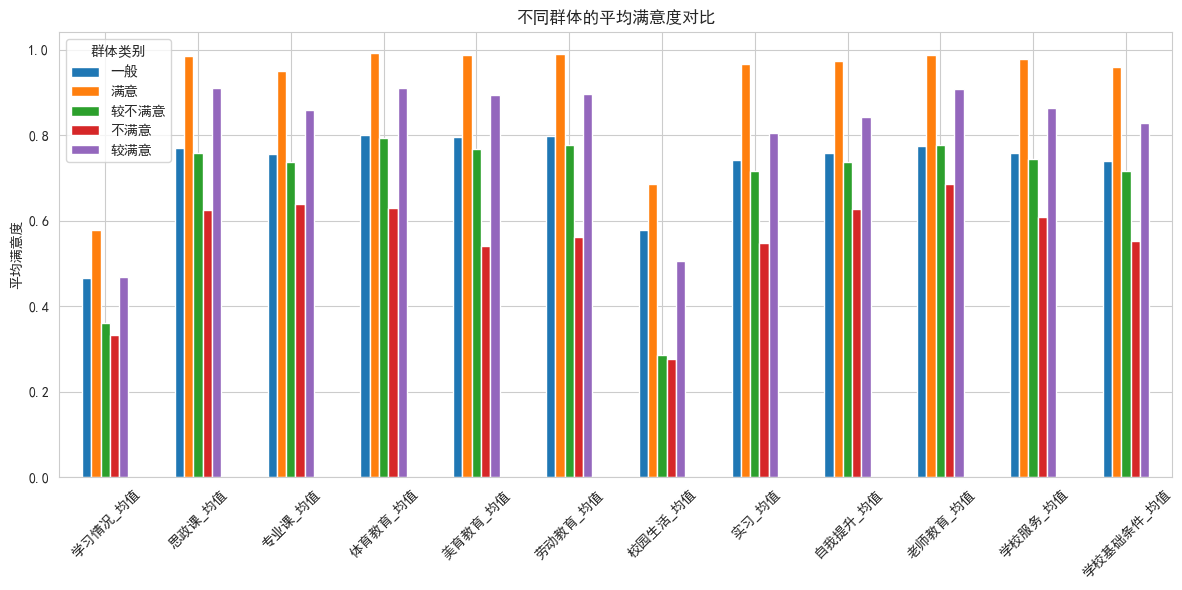

In [112]:
# ================================
# 8. 可视化群体满意度
# ================================
group_means.index = group_means.index.map(label_map)
group_means.T.plot(kind='bar', figsize=(12,6))
plt.title('不同群体的平均满意度对比')
plt.ylabel('平均满意度')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


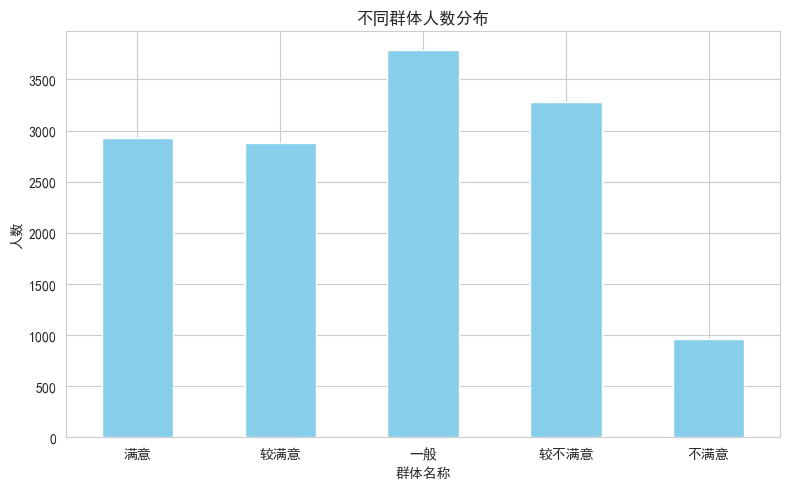

In [113]:
# ================================
# 9. 各群体人数分布
# ================================
group_counts = df['群体名称'].value_counts().reindex(labels_order)

plt.figure(figsize=(8,5))
group_counts.plot(kind='bar', color='skyblue')
plt.title('不同群体人数分布')
plt.ylabel('人数')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


区分群体的重要特征:
校园生活_均值    0.178599
学校服务_均值    0.124537
学习情况_均值    0.113163
自我提升_均值    0.099215
实习_均值      0.085734
专业课_均值     0.066089
思政课_均值     0.063137
劳动教育_均值    0.061428
老师教育_均值    0.058737
美育教育_均值    0.056599
dtype: float64


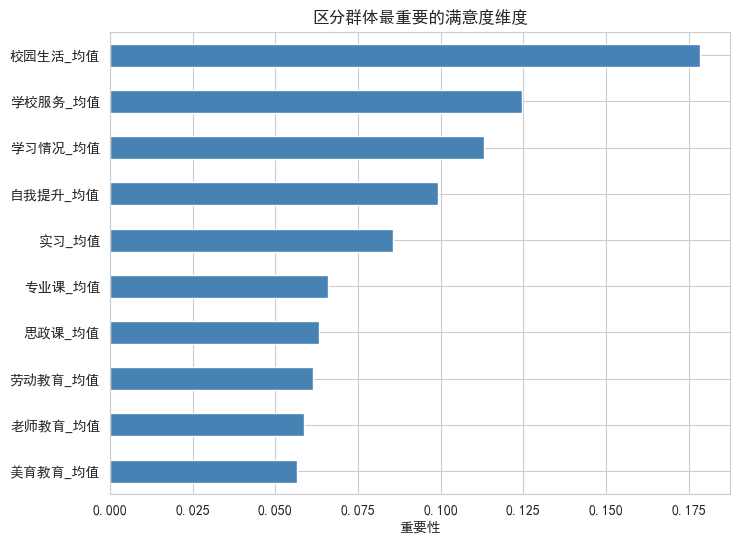

In [114]:
#通过 方差分析（ANOVA）/重要性分析 看哪些维度差异最大。

from sklearn.ensemble import RandomForestClassifier

# 用随机森林看特征重要性
clf = RandomForestClassifier(random_state=0)
clf.fit(X_scaled, df['群体类别'])

importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("区分群体的重要特征:")
print(importances.head(10))

importances.head(10).plot(kind='barh', figsize=(8,6), color='steelblue')
plt.title("区分群体最重要的满意度维度")
plt.xlabel("重要性")
plt.gca().invert_yaxis()
plt.show()

这部分的效果感觉不是很好

模型拟合效果评估：
训练集 R²: 0.967716004338519
测试集 R²: 0.9517167569280237
测试集 MSE: 0.000564988218202421
5折交叉验证 R² 平均值: 0.9574612585099043
--------------------------------------------------
Permutation 重要性（驱动综合满意度指数）:
学校服务_均值    0.118448
美育教育_均值    0.098874
自我提升_均值    0.068929
校园生活_均值    0.056859
思政课_均值     0.027838
劳动教育_均值    0.025169
实习_均值      0.012420
学习情况_均值    0.009419
体育教育_均值    0.007645
专业课_均值     0.006955
dtype: float64


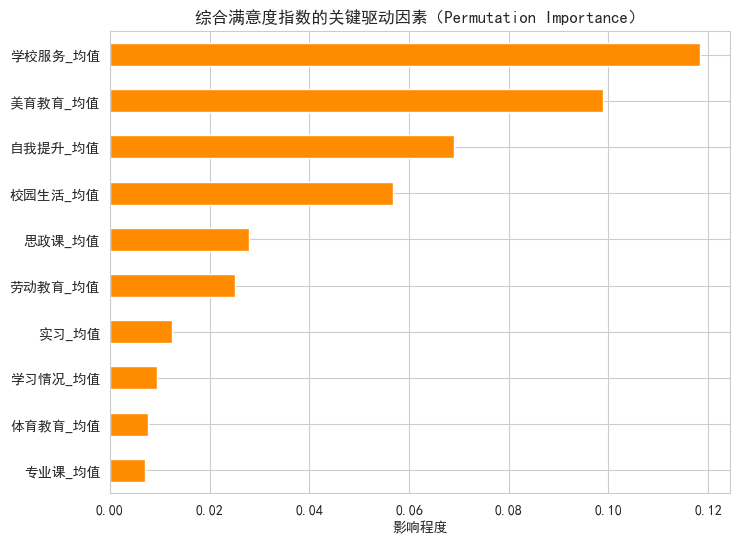

In [115]:
# ================================
# 11. 驱动“综合满意度指数”的关键因素（随机森林回归，避免过拟合）
# ================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# 定义综合满意度指数
df['综合满意度指数'] = df[feature_cols].mean(axis=1)

# 划分训练集 & 测试集（70% / 30%）
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df['综合满意度指数'], test_size=0.8, random_state=0
)

# 建立随机森林回归模型（限制树深度，避免过拟合）
rf = RandomForestRegressor(
    random_state=0,
    n_estimators=150,
    max_depth=6,
    min_samples_split=50
)
rf.fit(X_train, y_train)

# ========== (1) 模型拟合效果 ==========
print("模型拟合效果评估：")
print("训练集 R²:", r2_score(y_train, rf.predict(X_train)))
print("测试集 R²:", r2_score(y_test, rf.predict(X_test)))
print("测试集 MSE:", mean_squared_error(y_test, rf.predict(X_test)))

# 交叉验证 R²
scores = cross_val_score(rf, X_scaled, df['综合满意度指数'], cv=5, scoring='r2')
print("5折交叉验证 R² 平均值:", np.mean(scores))
print("-" * 50)

result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=0)

perm_importances = pd.Series(result.importances_mean, index=feature_cols).sort_values(ascending=False)
print("Permutation 重要性（驱动综合满意度指数）:")
print(perm_importances.head(10))

perm_importances.head(10).plot(kind='barh', figsize=(8,6), color='darkorange')
plt.title("综合满意度指数的关键驱动因素（Permutation Importance）")
plt.xlabel("影响程度")
plt.gca().invert_yaxis()
plt.show()
